In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
import os
import seaborn as sns
from tqdm.notebook import tqdm
import cv2 as op
import torch
from torchsummary import summary
import torchmetrics
import torchvision
from torchvision import transforms, models
import torch.nn as nn
import torch.nn.functional as f
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Prepare Dataset (Create Mappings and DataFrame)

In [21]:
PATH = 'dataset'

# Mapping labels to indices
label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i
    
id2label = {key : value for (value, key) in label2id.items()}

# Create a DataFrame for filenames and labels
filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])

df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
4050,dataset\normal\3295_left.jpg,3
3475,dataset\normal\2661_left.jpg,3
324,dataset\cataract\cataract_027.png,0
1544,dataset\diabetic_retinopathy\10782_left.jpeg,1
2500,dataset\glaucoma\Glaucoma_059.png,2


## Visualize Class Distribution

C:\Users\mo.ghareeb\AppData\Local\Temp\ipykernel_12292\550747362.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')


<Axes: xlabel='outcome', ylabel='count'>

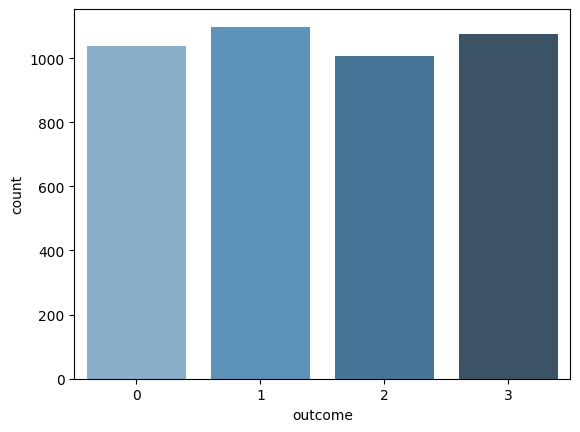

In [22]:
sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')


## Load and Display Sample Images

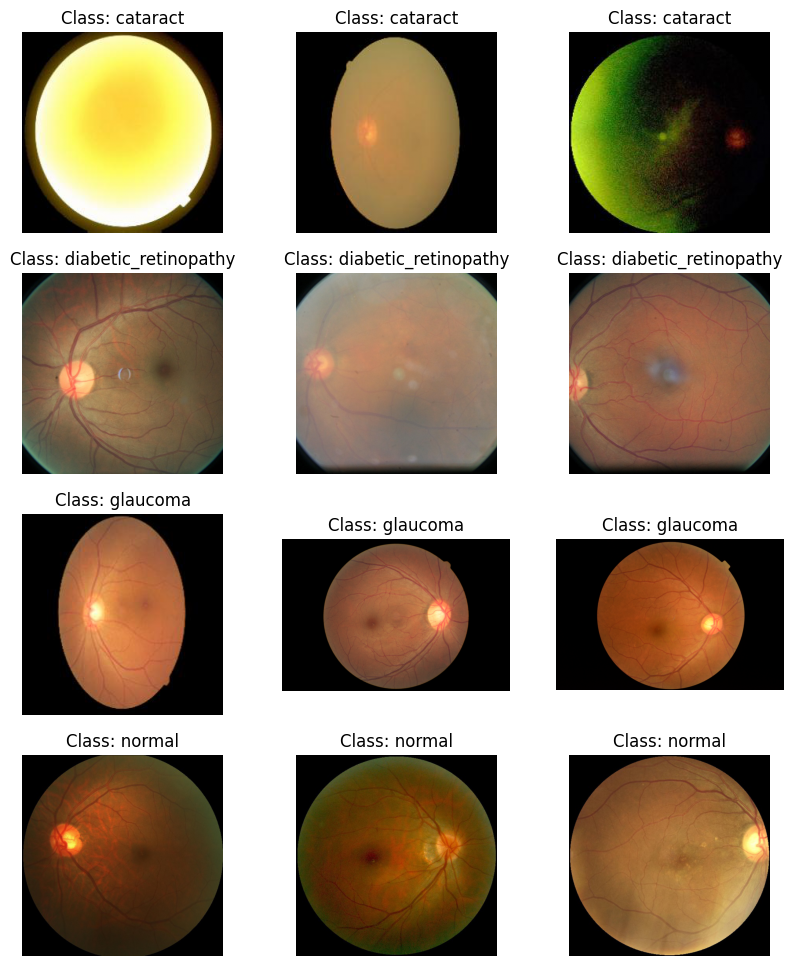

In [23]:
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min()) / img.max()
    return img

counter = 0
plt.figure(figsize = (10, 12))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1

plt.show()

## Data Transformation and data augmentation

In [31]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5)
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224))
])

## Define Custom Dataset Class

In [32]:
from torch.utils.data import Dataset

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform=None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, index):
        img = plt.imread(self.df.iloc[index, 0])
        label = self.df.iloc[index, 1]
        
        img = (img - img.min()) / img.max()
        
        if self.transform:
            img = self.transform(img)
            
        return img.to(torch.float32), label

## Prepare Train, Validation, and Test Sets

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

# Split data: First split into train+val (90%) and test (10%)
df_train_val, df_test = train_test_split(df, test_size=0.1, random_state=28)

# Now split the train+val data into train (80%) and val (10% of the original data)
df_train, df_val = train_test_split(df_train_val, test_size=0.1, random_state=28)

df_train.shape, df_val.shape, df_test.shape

((3415, 2), (380, 2), (422, 2))

## Create DataLoaders

In [34]:
from torch.utils.data import DataLoader

NUM_CLASSES = 4
BATCH_SIZE = 128

train_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)
test_dataset = EyeDataset(df_test, NUM_CLASSES, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check shape of data
a, b = next(iter(train_loader))
print(a.shape, b.shape)
del(a)
del(b)

torch.Size([128, 3, 224, 224]) torch.Size([128])


## Define the Model

In [35]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.resnet18(pretrained=True)
        
        # Freeze some layers of ResNet
        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False
            
        # Custom classification head
        self.block = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
        )
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()
        
    def get_optimizer(self):
        return torch.optim.AdamW([ 
            {'params': self.base.parameters(), 'lr': 3e-5},
            {'params': self.block.parameters(), 'lr': 8e-4}
        ])
        
    def forward(self, x):
        x = self.base(x)
        x = self.block(x)
        return x

## Define Trainer Class

In [36]:
class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, test_loader, device, save_path="eye_disease_model.pth"):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.save_path = save_path

        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        self.loss_fxn = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(self.device)

        self.history = {'train_loss': [], 'val_loss': [], 'test_loss': [],
                        'train_acc': [], 'val_acc': [], 'test_acc': []}

    def training_step(self, x, y):
        pred = self.model(x)
        loss = self.loss_fxn(pred, y)
        acc = self.accuracy(pred, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def test_step(self, x, y):
        with torch.no_grad():
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)

        return loss, acc

    def step_fxn(self, loader, step):
        loss, acc = 0, 0

        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device)
            l, a = step(X, y)
            loss, acc = loss + l.item(), acc + a.item()

        return loss / len(loader), acc / len(loader)

    def train(self, epochs):
        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)
            test_loss, test_acc = self.step_fxn(self.test_loader, self.test_step)

            for item, value in zip(self.history.keys(), [train_loss, val_loss, test_loss, train_acc, val_acc, test_acc]):
                self.history[item].append(value)

            print(f"[Epoch: {epoch + 1}] Train: [loss: {train_loss:.3f} acc: {train_acc:.3f}] "
                  f"Val: [loss: {val_loss:.3f} acc: {val_acc:.3f}] "
                  f"Test: [loss: {test_loss:.3f} acc: {test_acc:.3f}]")

        # Save the model after training
        self.save_model(self.model, self.save_path)

    def save_model(self, model, path):
        torch.save(model.state_dict(), path)
        print(f"Model saved to {path}")

In [37]:
# Instantiate and train the model
trainer = Trainer(train_loader, val_loader, test_loader, device)
summary(trainer.model.base, (3, 224, 224))
trainer.train(epochs=10)

d:\anconda\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anconda\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.792 acc: 0.691] Val: [loss: 0.528 acc: 0.795] Test: [loss: 0.466 acc: 0.839]


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.417 acc: 0.841] Val: [loss: 0.346 acc: 0.858] Test: [loss: 0.312 acc: 0.891]


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.287 acc: 0.898] Val: [loss: 0.294 acc: 0.876] Test: [loss: 0.266 acc: 0.880]


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.242 acc: 0.915] Val: [loss: 0.284 acc: 0.905] Test: [loss: 0.250 acc: 0.913]


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.214 acc: 0.919] Val: [loss: 0.268 acc: 0.913] Test: [loss: 0.206 acc: 0.895]


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 6] Train: [loss: 0.177 acc: 0.932] Val: [loss: 0.265 acc: 0.913] Test: [loss: 0.205 acc: 0.914]


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 7] Train: [loss: 0.156 acc: 0.940] Val: [loss: 0.240 acc: 0.900] Test: [loss: 0.187 acc: 0.920]


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 8] Train: [loss: 0.129 acc: 0.956] Val: [loss: 0.245 acc: 0.910] Test: [loss: 0.189 acc: 0.911]


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 9] Train: [loss: 0.121 acc: 0.954] Val: [loss: 0.272 acc: 0.895] Test: [loss: 0.200 acc: 0.918]


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 10] Train: [loss: 0.113 acc: 0.961] Val: [loss: 0.251 acc: 0.919] Test: [loss: 0.184 acc: 0.922]
Model saved to eye_disease_model.pth


## Plot Training Results

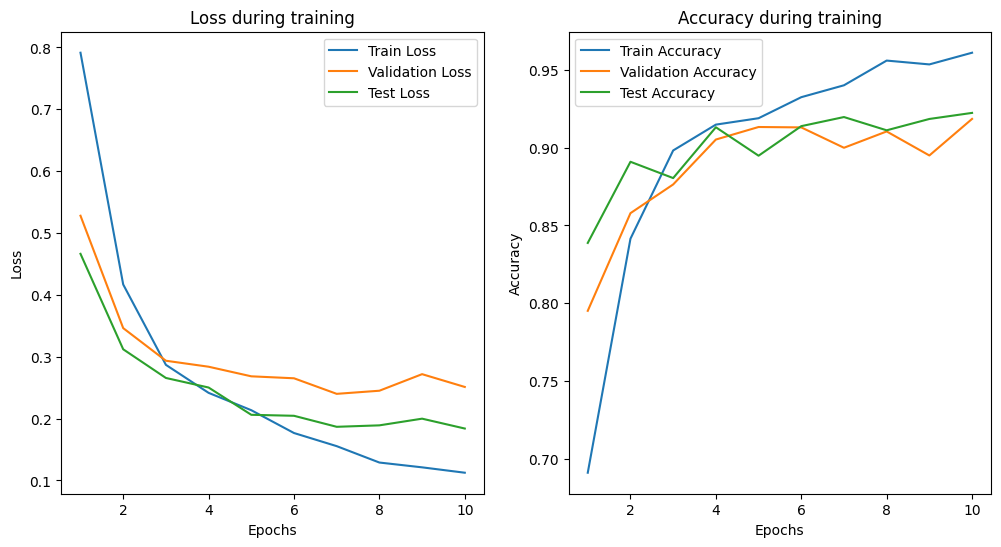

In [38]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.plot(epochs, history['test_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss during training')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.plot(epochs, history['test_acc'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy during training')

    plt.show()

# Call the plot function
plot_training_results(trainer.history)

## Evaluate the Model

In [39]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    test_loss, test_acc = trainer.step_fxn(test_loader, trainer.test_step)
    print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}")

# Evaluate the model on the test set
evaluate_model(trainer.model, trainer.test_loader, trainer.device)

  0%|          | 0/4 [00:00<?, ?it/s]

Test Loss: 0.160, Test Accuracy: 0.935


## Compute Metrics

                      precision    recall  f1-score   support

            cataract       0.97      0.95      0.96       104
diabetic_retinopathy       1.00      0.98      0.99       117
            glaucoma       0.89      0.87      0.88       102
              normal       0.84      0.89      0.86        99

            accuracy                           0.93       422
           macro avg       0.92      0.92      0.92       422
        weighted avg       0.93      0.93      0.93       422



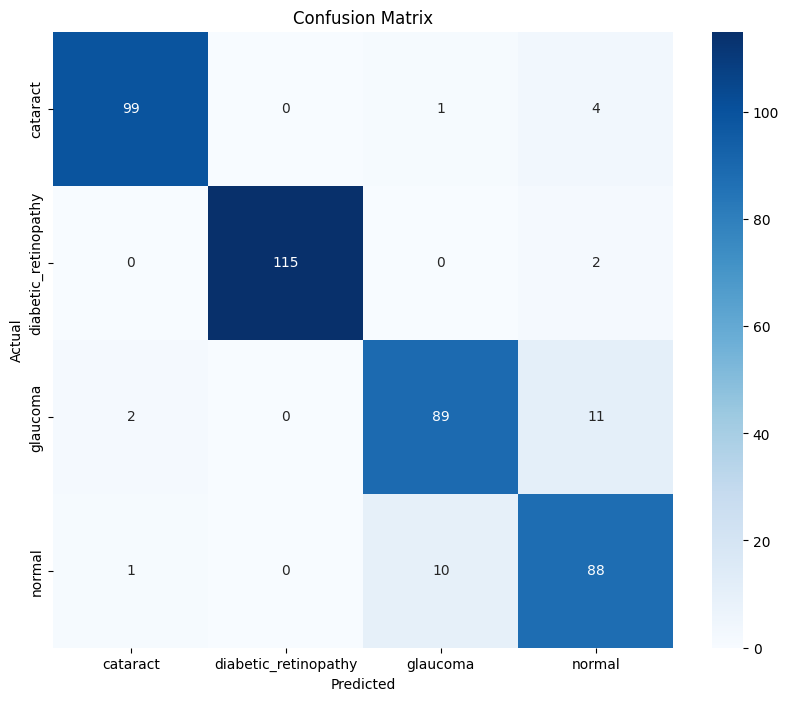

In [43]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def compute_metrics(model, test_loader, device, class_names=None):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            _, preds = torch.max(pred, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Print classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Example call (adjust based on your setup):
class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma','normal']  # Replace with actual class names
compute_metrics(trainer.model, trainer.test_loader, trainer.device, class_names=class_names)

## Visualize Predictions

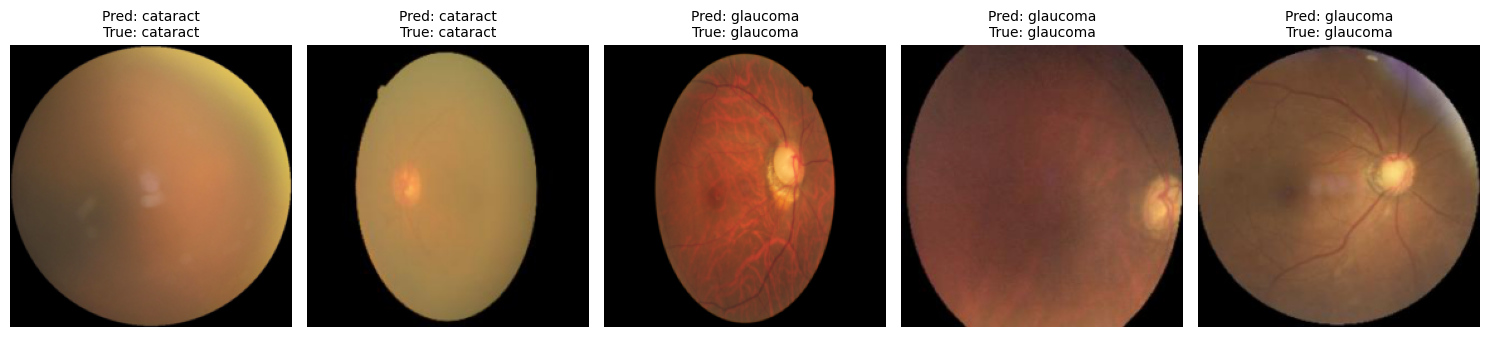

In [46]:
def visualize_predictions(model, test_loader, device, class_names, num_images=5):
    model.eval()  # Set model to evaluation mode
    
    images_so_far = 0
    fig = plt.figure(figsize=(15, 8))  # زيادة حجم الشكل لتجنب التداخل
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for i in range(inputs.size()[0]):
                if images_so_far == num_images:
                    plt.tight_layout()  # تحسين التخطيط
                    plt.show()
                    return
                images_so_far += 1
                
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                
                # تحويل الصورة إلى PIL للعرض
                img = inputs.cpu().data[i]
                img = transforms.ToPILImage()(img)
                ax.imshow(img)
                
                # عرض أسماء الفئات بدلاً من الأرقام
                pred_label = class_names[preds[i].item()]
                true_label = class_names[labels[i].item()]
                ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)  # فصل النصوص بسطر جديد
    
    plt.tight_layout()  # تحسين التخطيط لتجنب التداخل
    plt.show()

# Example call
class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']  # Replace with your actual class names
visualize_predictions(trainer.model, trainer.test_loader, trainer.device, class_names=class_names)

## Test predictions

In [47]:
def predict_image(image_path, model, transform, device, id2label):
    """
    Predict the class of a single image using the trained model.
    
    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Trained model.
        transform (torchvision.transforms.Compose): Transformations for the image.
        device (str): Device ('cuda' or 'cpu') to use for prediction.
        id2label (dict): Mapping from class IDs to labels.
        
    Returns:
        str: Predicted class label.
    """
    model.eval()
    
    # Load and preprocess the image
    image = plt.imread(image_path)
    if image.shape[-1] == 4:  # Check for 4 channels
        image = image[:, :, :3]  # Convert RGBA to RGB by removing the alpha channel
    
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
    
    # Predict
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
    
    # Return the label
    return id2label[pred]

d:\anconda\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anconda\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\mo.ghareeb\AppData\Local\Temp\ipykernel_12292\2938892621.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main

Predicted label: glaucoma


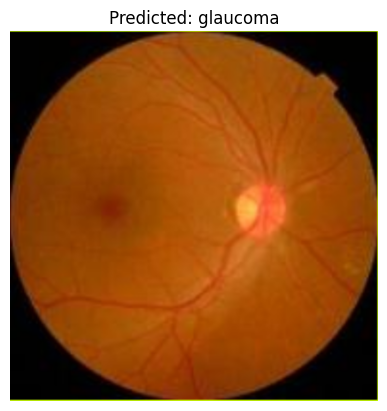

In [48]:
# Path to the image to test
test_image_path = "Screenshot 2024-12-29 002023.png"

# Load the trained model
trained_model = Net()
trained_model.load_state_dict(torch.load("eye_disease_model.pth"))
trained_model.to(device)

# Predict the class of the image
predicted_label = predict_image(test_image_path, trained_model, val_transform, device, id2label)

print(f"Predicted label: {predicted_label}")

# Display the image with the prediction
img = plt.imread(test_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label}")
plt.show()